# Extraction of One spectrum
=============================================

- Creation : Tuesday 2016 June 14th
- Update / July 7th 2016
- Author Sylvie Dagoret-Campagne 
- affiliation : LAL/IN2P3/CNRS

Study spectrum of HD158485


## 1) Import package

In [491]:
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [492]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [493]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [494]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-07-07 13:52:41.576148
fits date format for the analysis :  2016-07-07T13:52:41


In [495]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.background import Background2D

## Few Definition

In [496]:
fileindex=11;

In [497]:
object_name='HD158485_grat_'+str(fileindex)

In [498]:
path='./HD158485_grat'
basefilename='AssScImHD158485_grat_'+str(fileindex)+'.fits' # check master bias
filename=os.path.join(path,basefilename)
outputfigfilename='ScienceImageAssemblerInput_img.pdf'
outputfigfilename2='ReorderedImage_'+object_name+'_img.pdf'
outputfigfilename3='SingleImage_'+object_name+'_img.pdf'
outputfigfilename4='RotatedImage_'+object_name+'_img.pdf'
outputfigfilename5='SpectrumRegion_'+object_name+'_img.pdf'
outputfigfilename6='SpectrumHisto_'+object_name+'_img.pdf'
outputfigfilename7='SpectrumLogHisto_'+object_name+'_img.pdf'

## Analysis Selection

In [499]:
RotationAngleOptimisation=False

In [500]:
BackgroundSubtractionFlag=False

In [501]:
BackgroundSubtractionFlag1=False  # must be opposite
BackgroundSubtractionFlag2=True

In [502]:
CropLittleStarFlag=False

## 4) Read the images

In [503]:
hdulist = fits.open(filename)

In [504]:
prim_hdr = hdulist[0].header

In [505]:
exposure = prim_hdr['EXPOSURE']
date_obs = prim_hdr['DATE-OBS']

In [506]:
print date_obs
print 'exposure = ',exposure,'seconds'

2016-05-12T04:11:32.661
exposure =  5.0 seconds


In [507]:
allimages = []
ccd_chan = ccdproc.CCDData.read(filename, hdu=0,unit='adu') 
allimages.append(ccd_chan)

## 5) Shows the images

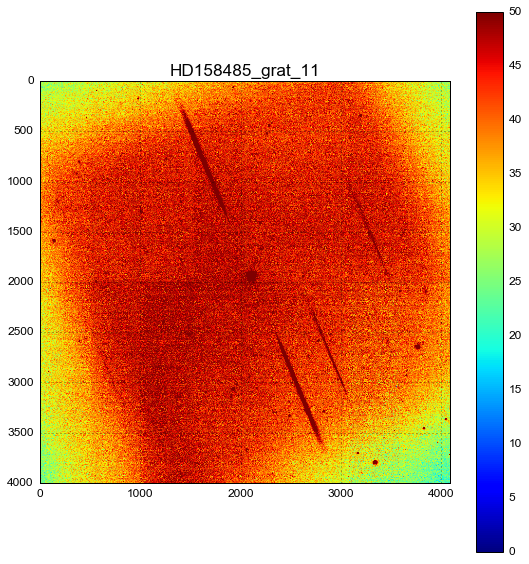

In [508]:
fig, ax = plt.subplots(figsize=(8, 8))
img=ax.imshow(ccd_chan,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)
plt.grid(True)
plt.savefig(outputfigfilename3)

## Background subtraction

The user should decide if the background must be subtracted or not

In [509]:
if BackgroundSubtractionFlag:
    bkg = Background2D(ccd_chan, (100, 100), filter_size=(3, 3),method='median')
    data=ccd_chan - bkg.background
    print('median background = ',bkg.background_median)
    print('median rms = ',bkg.background_rms_median)
else:
    data=ccd_chan

In [510]:
data=data.divide(exposure)   # normalisation to one second exposure

This calculation of sky background has to be used to erase the central star

In [511]:
skybackground=np.median(data)
sigma_skybackground=np.std(data)

In [512]:
print 'remaing sky background = {:2.3f} +/- {:2.3f}'.format(skybackground,sigma_skybackground)

remaing sky background = 8.541 +/- 14.652


## 8.) Image rotation and spectrum region selection

In [513]:
rotation_angle_test=np.linspace(67.0,67.5,100)

In [514]:
NBTESTS=rotation_angle_test.shape[0]

### Optimisation to find the best rotation angle

In [515]:
flux=np.zeros(NBTESTS)

In [516]:
w=10   # spectrum width selection
       # ------------------------
ws=100 # Central star width : must be that large especially for 5 seconds exposures
       #-------------------

In [517]:
if RotationAngleOptimisation:
    for index,angle in np.ndenumerate(rotation_angle_test):
        rotated_image=ndimage.interpolation.rotate(data,angle)
        imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
        region=rotated_image[imax-w: imax+w,480:4830]  # extract the region
        imax2,jmax2 = np.unravel_index(region.argmax(), region.shape)
        region[:,jmax2-ws:jmax2+ws]=skybackground  # suppress central star
        flux[index]=region.sum()
        print 'index = {} angle={:2.4f} flux = {:2.0f}'.format(index,angle,flux[index])

In [518]:
if RotationAngleOptimisation:
    dflux=flux-flux.max()
    plt.plot(rotation_angle_test,dflux)

In [519]:
if not RotationAngleOptimisation:
    selected_angle=67.28787879

In [520]:
if RotationAngleOptimisation:
    selected_angle= rotation_angle_test[np.where(flux==flux.max())]

In [521]:
print 'selected angle = {} degrees'.format(selected_angle)

selected angle = 67.28787879 degrees


In [522]:
rotated_image=ndimage.interpolation.rotate(data,selected_angle)

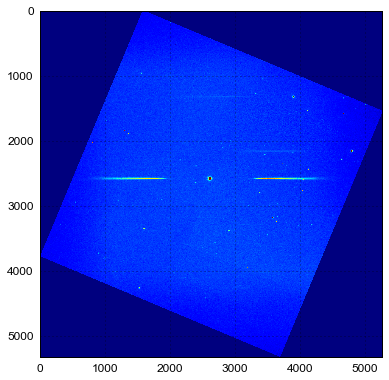

In [523]:
plt.imshow(rotated_image,vmin=0,vmax=50)

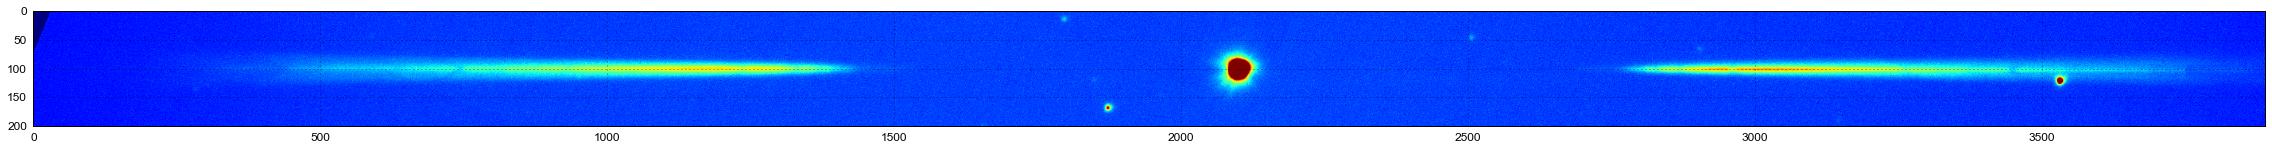

In [524]:
wcheck=100
imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
check_region=np.copy(rotated_image[imax-wcheck: imax+wcheck,510:4400])  # extract the region
fig, ax = plt.subplots(figsize=(40, 40))
ax.imshow(check_region,vmin=0,vmax=50)

### Do the rotation for the selected  angle

In [525]:
themaximum=rotated_image.max()

In [526]:
imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
print imax,' ',jmax

2578   2606


In [527]:
np.where(rotated_image==rotated_image.max())

(array([2578]), array([2606]))

In [528]:
profile1=np.sum(rotated_image[:,800:1000],axis=1)
profile2=np.sum(rotated_image[:,1000:2000],axis=1)
profile3=np.sum(rotated_image[:,3000:3800],axis=1)
profile4=np.sum(rotated_image[:,4000:4600],axis=1)

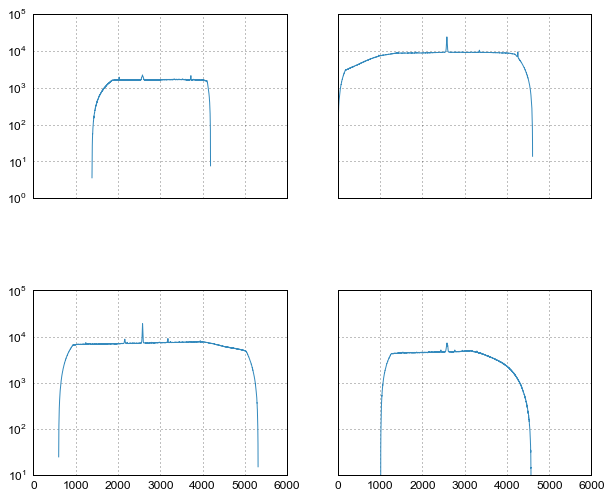

In [529]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col',sharey='row',figsize=(10.,8))
ax1.semilogy(profile1)
ax2.semilogy(profile2)
ax3.semilogy(profile3)
ax4.semilogy(profile4)
#ax1.plot(profile1)
#ax2.plot(profile2)
#ax3.plot(profile3)
#ax4.plot(profile4)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)

In [530]:
the_imax1=np.where(profile1==profile1.max())
the_imax2=np.where(profile2==profile2.max())
the_imax3=np.where(profile3==profile3.max())
the_imax4=np.where(profile4==profile4.max())

In [531]:
print the_imax1,the_imax2,the_imax3,the_imax4,

(array([2578]),) (array([2579]),) (array([2580]),) (array([2582]),)


### find the true vertical center of the images

Want to find the vertical position of the axis

In [532]:
imax=int(np.median([the_imax1,the_imax2,the_imax3,the_imax4]))

In [533]:
imax # correct for the vertical position of the center
     #------------------------------------------------ 

2579

In [534]:
w=10  # This is the width we will use to get the spectrum
      #---------------------------------------------------

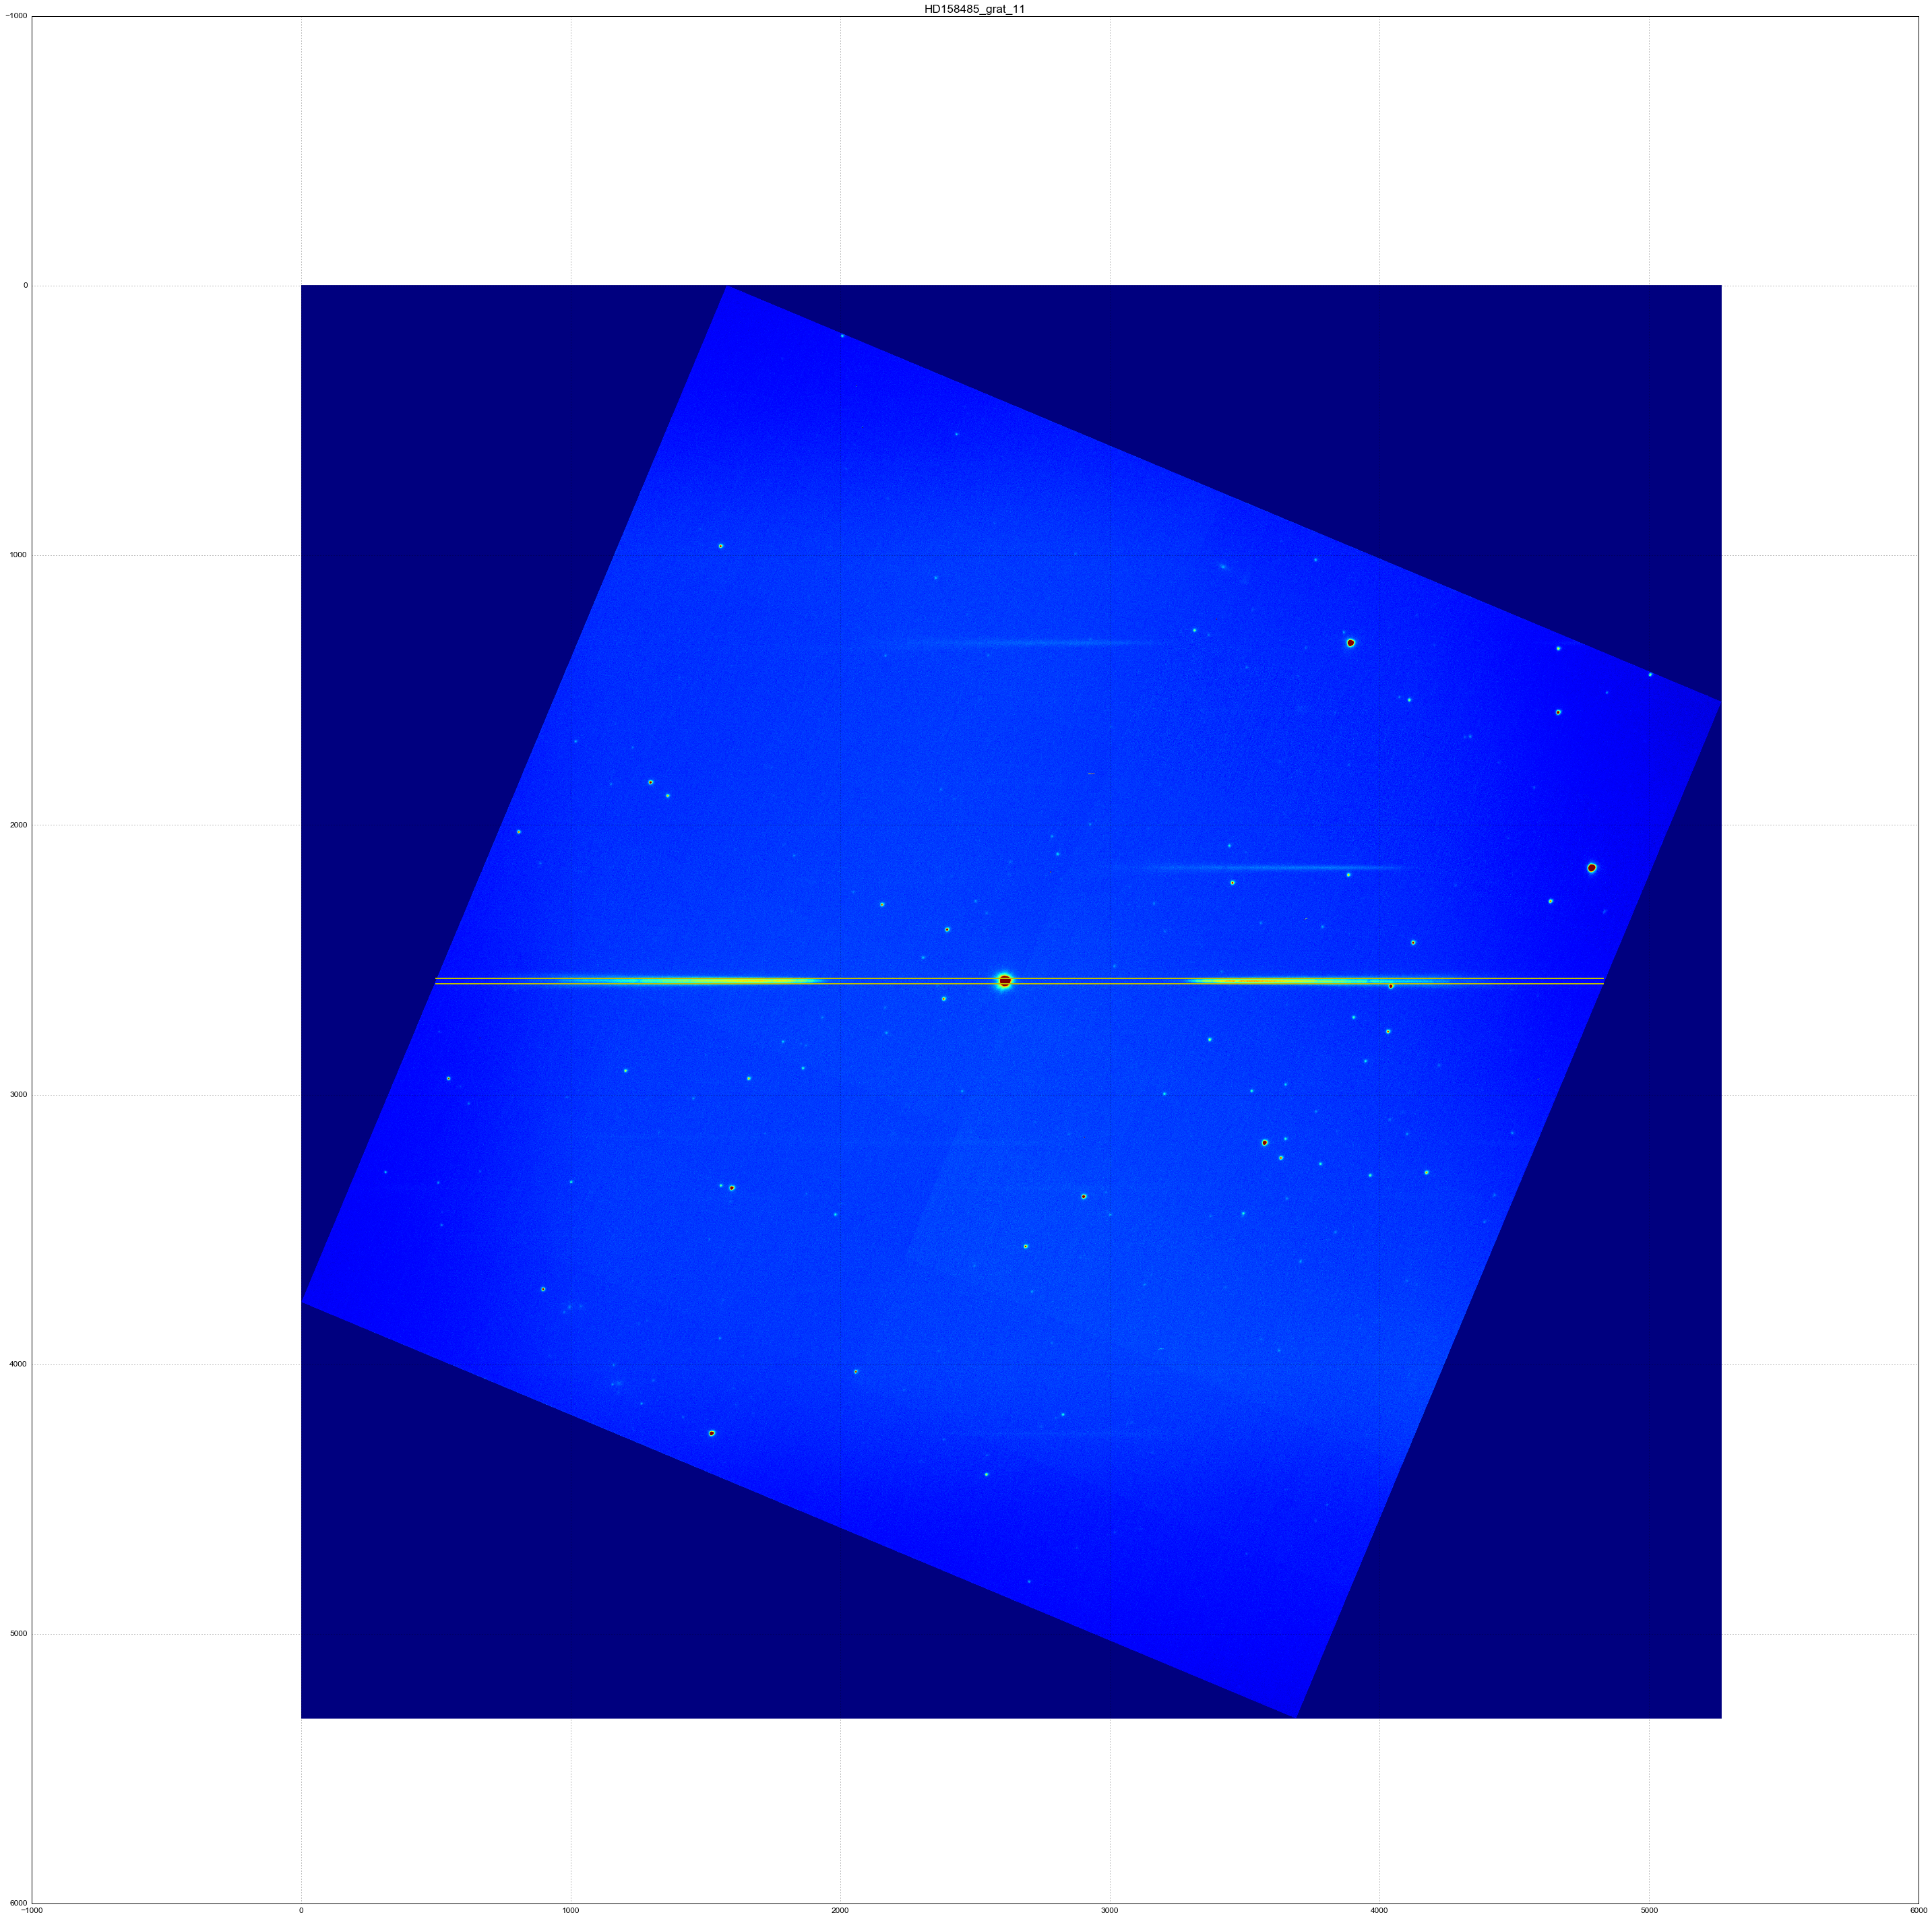

In [535]:
# check the central region is OK
# -------------------------------
fig, ax = plt.subplots(figsize=(40, 40))
ax.imshow(rotated_image,vmin=0,vmax=50.)
ax.plot([500, 4830], [imax-w, imax-w], color='y', linestyle='-', linewidth=2)
ax.plot([500, 4830], [imax+w, imax+w], color='y', linestyle='-', linewidth=2)
plt.title(object_name)
plt.tight_layout()
plt.savefig(outputfigfilename4)

In [536]:
# Big view of the spectrum region of reference
#----------------------------------------------

# it also contains the region used to compute background
#
SpectrumRegion=rotated_image[imax-100: imax+100,:]

In [537]:
# Copy of the working region
#-------------------------
SpectrumRegionNew=np.copy(SpectrumRegion)   # must coy the original spectrum not to overwrite the original

In [538]:
imax2,jmax2 = np.unravel_index(SpectrumRegionNew.argmax(), SpectrumRegionNew.shape)
print imax2,' ',jmax2

99   2606


In [539]:
# put background where the central star is
#-----------------------------------------
SpectrumRegionNew[:,jmax2-ws: jmax2+ws]=skybackground # remove the big central star and replace by background

### Extract the region of the spectrum  from the rotated image

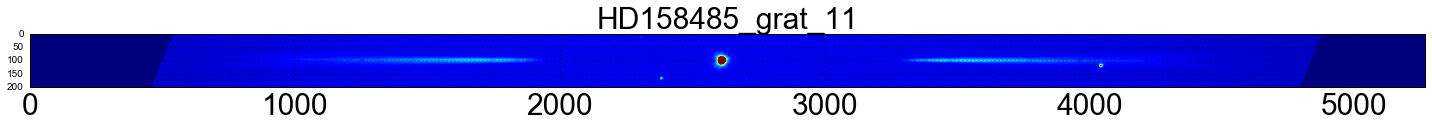

In [540]:
# show the original spectrum region
#---------------------------------
fig, ax = plt.subplots(figsize=(25, 25))
ax.imshow(SpectrumRegion,vmin=0,vmax=100.)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=10)
ax.grid(True)
plt.title(object_name,fontsize=30)


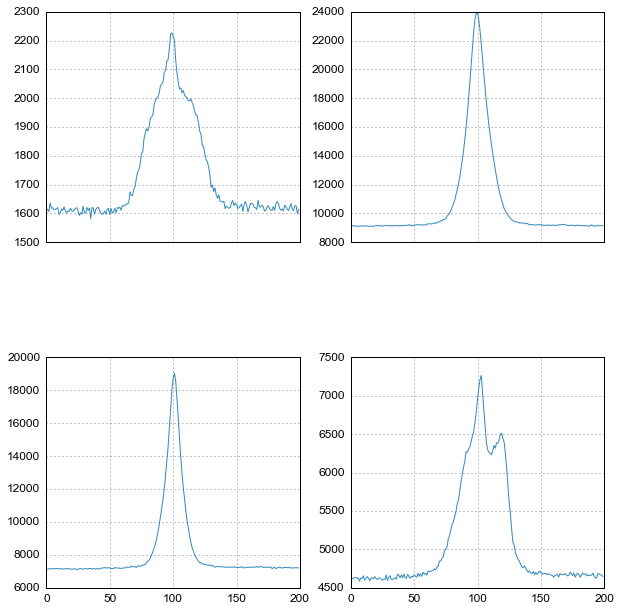

In [541]:
# check the vertical position of the center along the dispersion axis
#---------------------------------------------------------------------
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col',figsize=(10.,10))
ax1.plot(np.sum(SpectrumRegion[:,800:1000],axis=1))
ax2.plot(np.sum(SpectrumRegion[:,1000:2000],axis=1))
ax3.plot(np.sum(SpectrumRegion[:,3000:3800],axis=1))
ax4.plot(np.sum(SpectrumRegion[:,4000:4600],axis=1))
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)

### Show the spectrum region with the central star removed

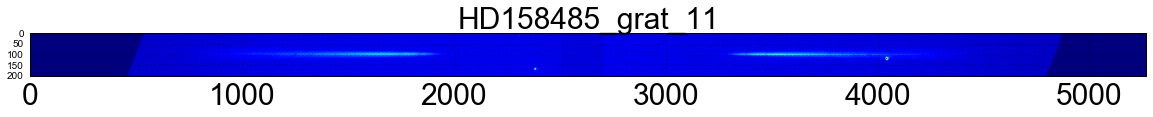

In [542]:
# show the spectrum cropped from central star
#--------------------------------------------
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SpectrumRegionNew,vmin=0,vmax=100.)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=10)
ax.grid(True)
plt.title(object_name,fontsize=30)

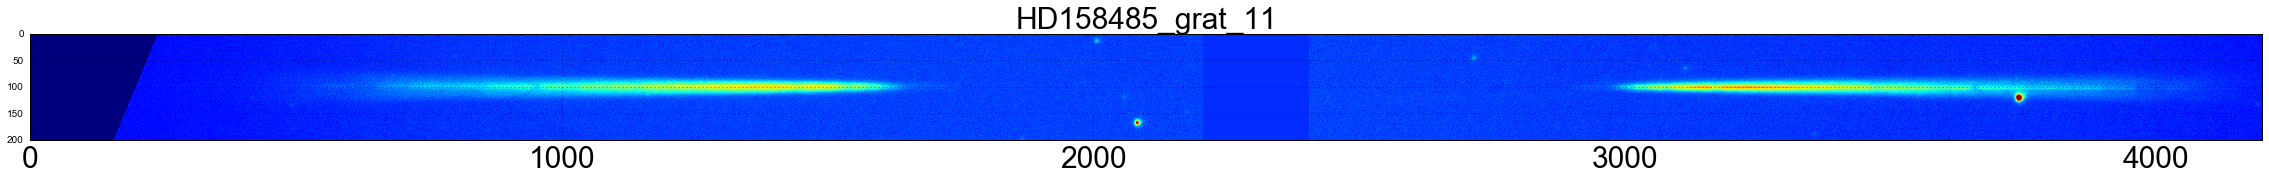

In [543]:
# idem but with a zoom
#----------------------
fig, ax = plt.subplots(figsize=(40, 40))
ax.imshow(SpectrumRegionNew[:,300:4500],vmin=0,vmax=50.)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=10)
ax.grid(True)
plt.title(object_name,fontsize=30)

### Crop little star on the right wing

In [544]:
ymax3,xmax3=np.where(SpectrumRegionNew==SpectrumRegionNew.max())

In [545]:
print ymax3,xmax3

[121] [4040]


In [546]:
littlestarsize=15    # be carefull the extinction of the tiny star should not be that big

In [547]:
SpectrumRegionNew.shape

(200, 5268)

In [548]:
# total size the of Spectrum region in X and Y
#----------------------------------------------
X_SRN=np.arange(SpectrumRegionNew.shape[1])
Y_SRN=np.arange(SpectrumRegionNew.shape[0])

In [549]:
# generate a grid (XV_SRN, YV_SRN are 2D)
#----------------------------------------
XV_SRN, YV_SRN = np.meshgrid(X_SRN, Y_SRN, sparse=False, indexing='ij')

In [550]:
# Get the coordinates of the points inside the star disk
#--------------------------------------------------------
Xlsr,Ylsr=np.where( (XV_SRN-xmax3)**2+(YV_SRN-ymax3)**2<littlestarsize**2)

In [551]:
selected_indexes=zip(Ylsr,Xlsr)

In [552]:
# here the little star is erased
#---------------------------------
for ii,jj in selected_indexes:
    SpectrumRegionNew[ii,jj]=skybackground

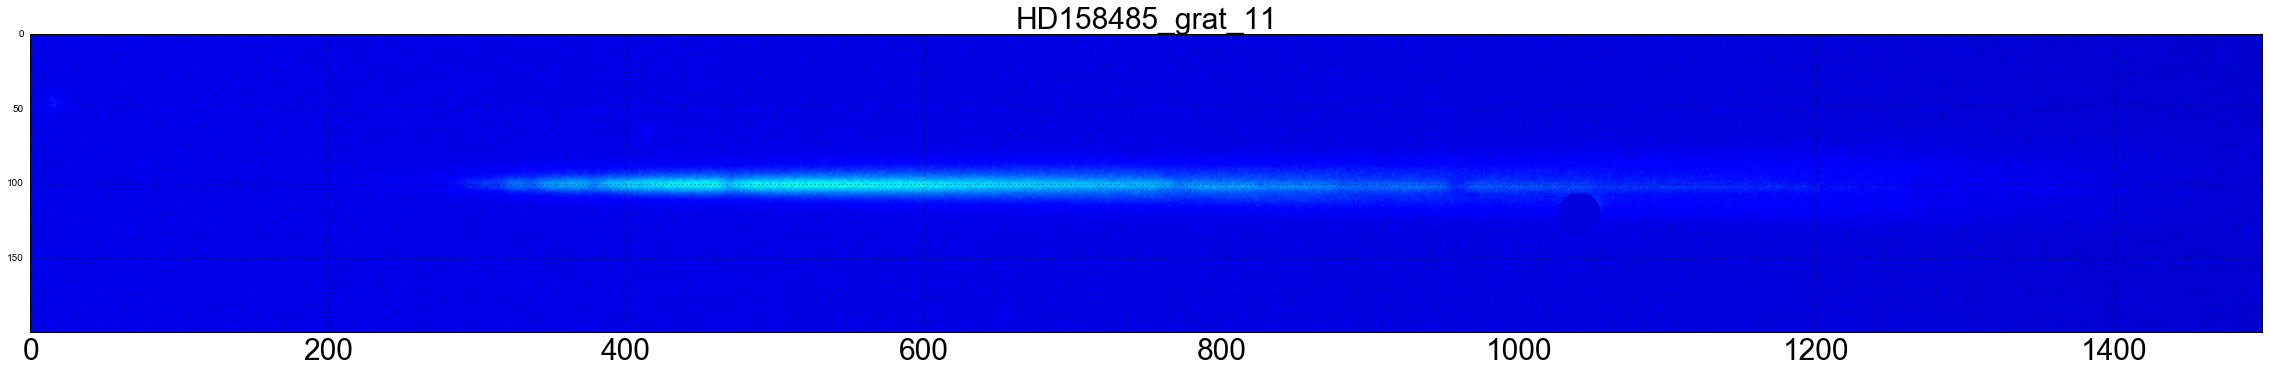

In [553]:
# check the liitle star is erased
#---------------------------------
fig, ax = plt.subplots(figsize=(40, 40))
ax.imshow(SpectrumRegionNew[:,3000:4500],vmin=0,vmax=100.)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=10)
plt.title(object_name,fontsize=30)

### check the transverse profile

In [554]:
part=SpectrumRegion[:,4000:4500]

In [555]:
part.shape

(200, 500)

In [556]:
pro=np.sum(part,axis=1)

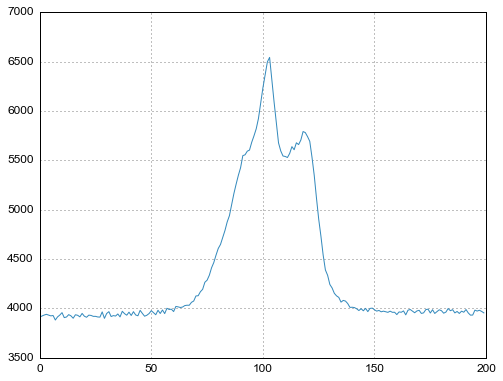

In [557]:
# see la patte d'oiseau à la fin 
plt.plot(pro)

## Optimize the width


The width is varied from zero to the Spectrum Region width to study the "encircled energy" versus width

In [558]:
widths=np.arange(1,100,1)

In [559]:
widths

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [560]:
NBWIDTHS=widths.shape[0]

In [561]:
profile_list=[]
integratedflux=np.zeros(NBWIDTHS)

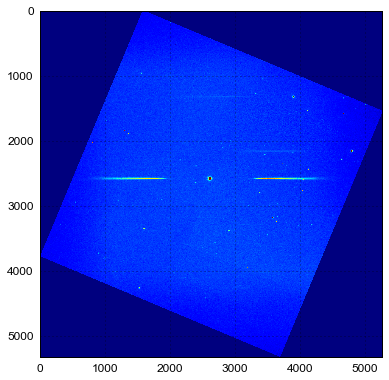

In [562]:
plt.imshow(rotated_image,vmin=0,vmax=50)  

In [563]:
#imax,jmax = np.unravel_index(SpectrumRegionNew.argmax(), SpectrumRegionNew.shape)
#print imax,' ',jmax
for index,thew in np.ndenumerate(widths):
    
    TestRegion=np.copy(rotated_image[imax-thew: imax+thew,480:4830])
    imax2,jmax2 = np.unravel_index(TestRegion.argmax(), TestRegion.shape)
    TestRegion[:,jmax2-ws: jmax2+ws]=skybackground  # remove the star
    TestRegion=TestRegion-skybackground  # now must remove the sky background to all the pixels
    profile=np.sum(TestRegion,axis=1)
    integratedflux[index]=profile.sum()
    profile_list.append(profile)
    

In [564]:
imax2,jmax2 = np.unravel_index(SpectrumRegion.argmax(), SpectrumRegion.shape)
print imax2,' ',jmax2

for index,thew in np.ndenumerate(widths):
    
    TestRegion=np.copy(SpectrumRegionNew[imax2-thew: imax2+thew,:])   # this spectrum has already the little star removed
    #imax2,jmax2 = np.unravel_index(TestRegion.argmax(), TestRegion.shape)
    #TestRegion[:,jmax2-ws: jmax2+ws]=skybackground  # remove the star
    TestRegion=TestRegion-skybackground  # now must remove the sky background to all the pixels
    profile=np.sum(TestRegion,axis=1)
    integratedflux[index]=profile.sum()
    profile_list.append(profile)
    

99   2606


In [565]:
integratedflux=integratedflux/integratedflux.max()

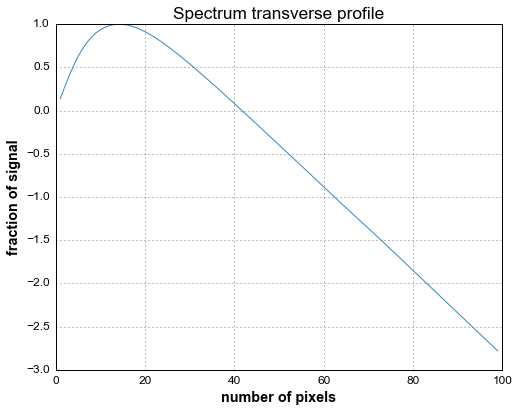

In [566]:
plt.plot(widths,integratedflux)
plt.title('Spectrum transverse profile')
plt.xlabel('number of pixels')
plt.ylabel('fraction of signal')

### Select the final window width for the spectrum

In [567]:
wsel=20  # should be 20, but set 10 due to the star
         #-------------------------------------------

## 9) Final Extraction of the spectrum from the image

In [568]:
# take again the Selected spectrum region but this time with the selected width wsel
#---------------------------------------------------------------------------------
imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
print imax,' ',jmax
SelectedSpectrumRegion=np.copy(rotated_image[imax-wsel: imax+wsel,:])

2578   2606


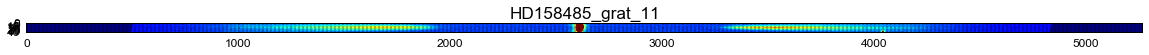

In [569]:
# plot the final selected region for the spectrum
#---------------------------------------------
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SelectedSpectrumRegion,vmin=0,vmax=50.)
plt.title(object_name)

#### remove central star

In [570]:
# Remove the central star in the new selected region
#-------------------------------------------------------
imax2,jmax2 = np.unravel_index(SelectedSpectrumRegion.argmax(), SelectedSpectrumRegion.shape)
print imax2,' ',jmax2

20   2606


In [571]:
SelectedSpectrumRegion[:,jmax2-ws: jmax2+ws]=skybackground

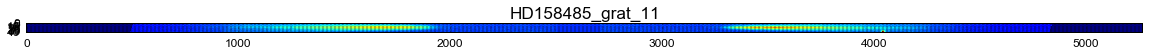

In [572]:
# Check the central star has been erased
# ---------------------------------------
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SelectedSpectrumRegion,vmin=0,vmax=50.)
plt.title(object_name)
#plt.tight_layout()
plt.savefig(outputfigfilename5)

In [573]:
# Crope the littlestar of selected
#----------------------------------
if CropLittleStarFlag:
    ymax4,xmax4=np.where(SelectedSpectrumRegion==SelectedSpectrumRegion.max())
    X_SRN=np.arange(SelectedSpectrumRegion.shape[1])
    Y_SRN=np.arange(SelectedSpectrumRegion.shape[0])
    XV_SRN, YV_SRN = np.meshgrid(X_SRN, Y_SRN, sparse=False, indexing='ij')
    Xlsr,Ylsr=np.where( (XV_SRN-xmax4)**2+(YV_SRN-ymax4)**2<littlestarsize**2)
    selected_indexes=zip(Ylsr,Xlsr)
    for ii,jj in selected_indexes:
        SelectedSpectrumRegion[ii,jj]=skybackground

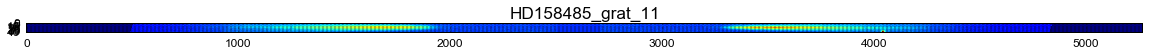

In [574]:
# Check the little star has been removed
#----------------------------------------
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SelectedSpectrumRegion,vmin=0,vmax=50.)
plt.title(object_name)
#plt.tight_layout()
plt.savefig(outputfigfilename5)

## Extract up and down bands to compute the background

#### Background method 1

- 2D subtraction

In [575]:
SelectedBackgroundUpRegion=np.copy(rotated_image[imax-wsel-100: imax+wsel-100,:])

In [576]:
SelectedBackgroundDownRegion=np.copy(rotated_image[imax-wsel+100: imax+wsel+100,:])

In [577]:
SelectedBackgroundMinRegion=np.where(np.less_equal(SelectedBackgroundUpRegion,SelectedBackgroundDownRegion),SelectedBackgroundUpRegion , SelectedBackgroundDownRegion)

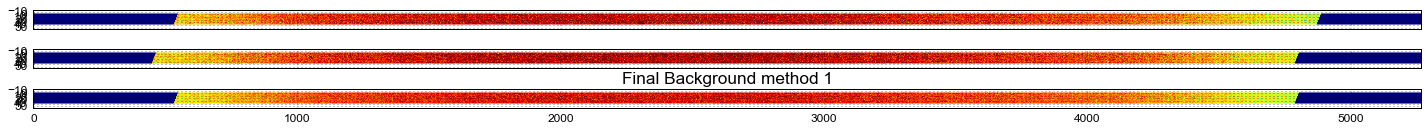

In [578]:
# plot the two background region
# ---------------------------------------
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(20, 2))
ax1.imshow(SelectedBackgroundUpRegion,vmin=0,vmax=10.)
ax2.imshow(SelectedBackgroundDownRegion,vmin=0,vmax=10.)
ax3.imshow(SelectedBackgroundMinRegion,vmin=0,vmax=10.)
plt.tight_layout()
plt.title('Final Background method 1')
plt.show()

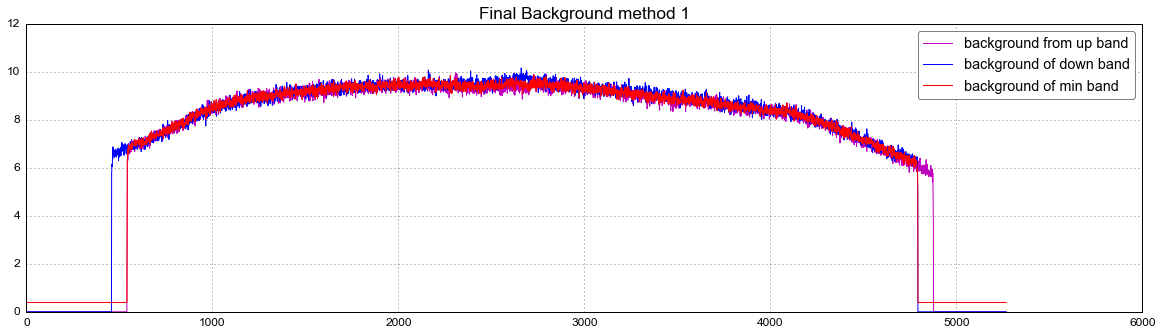

In [579]:
BackgUp=np.median(SelectedBackgroundUpRegion,axis=0)  # median along the vertical
BackgDo=np.median(SelectedBackgroundDownRegion,axis=0) # median along the vertical
BackgMi=np.median(SelectedBackgroundMinRegion,axis=0) # median along the vertical

m1=np.median(BackgUp)
m2=np.median(BackgDo)
m0=np.median(BackgMi)

BackgMi=BackgMi+ ((m1+m2)/2-m0)  # remove the bias induced by the min

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(BackgUp,color='m',label='background from up band')
ax.plot(BackgDo,color='b',label='background of down band')
ax.plot(BackgMi,color='r',label='background of min band')
plt.title('Final Background method 1')
#plt.ylim(0,4.5)
plt.legend()
plt.show()

In [580]:
FinalBackground1=SelectedBackgroundMinRegion+((m1+m2)/2-m0)  # 2D

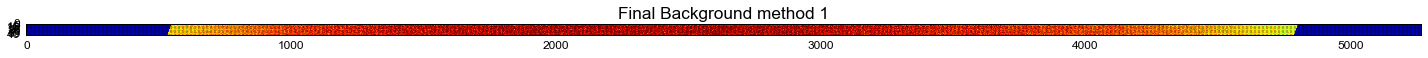

In [581]:
# plot the final background region
# ---------------------------------------
fig, ax1 = plt.subplots(1,1,figsize=(20, 2))
ax1.imshow(FinalBackground1,vmin=0,vmax=10.)
plt.title('Final Background method 1')
plt.tight_layout()

In [582]:
BackgSpecFinal1=np.median(FinalBackground1,axis=0) # median along the vertical

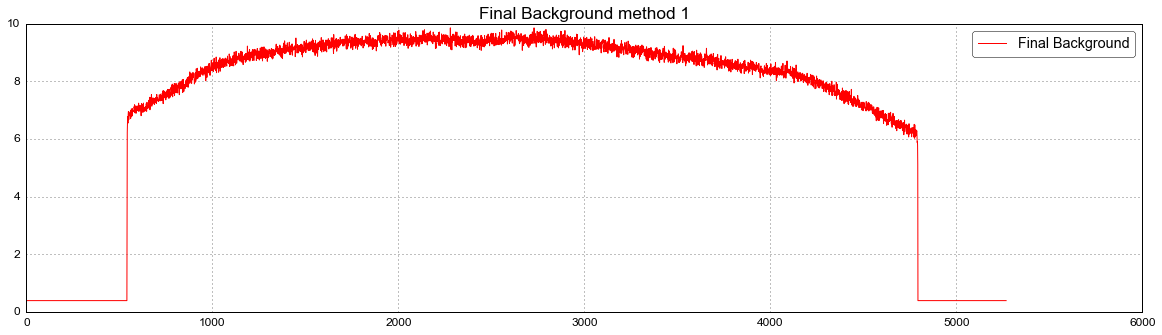

In [583]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(BackgSpecFinal1,color='r',label='Final Background')
plt.title('Final Background method 1')
plt.legend()
#plt.ylim(0,4.5)
plt.show()

#### method2 :
- One 1D subtraction only but with a larger region


In [584]:
wselbg2=5*wsel   # should be 100 in width

SelectedBackgroundUpRegion2=np.copy(rotated_image[imax-wsel-200: imax+wsel-200,:])
SelectedBackgroundDownRegion2=np.copy(rotated_image[imax-wsel+200: imax+wsel+200,:])
SelectedBackgroundMinRegion2=np.where(np.less_equal(SelectedBackgroundUpRegion2,SelectedBackgroundDownRegion2),SelectedBackgroundUpRegion2 , SelectedBackgroundDownRegion2)

In [585]:
BackgUp2=np.median(SelectedBackgroundUpRegion2,axis=0)  # median along the vertical
BackgDo2=np.median(SelectedBackgroundDownRegion2,axis=0) # median along the vertical
BackgMi2=np.median(SelectedBackgroundMinRegion2,axis=0) # median along the vertical

m1=np.median(BackgUp2)
m2=np.median(BackgDo2)
m0=np.median(BackgMi2)

BackgMi2=BackgMi2+ ((m1+m2)/2-m0)  # remove the bias induced by the min



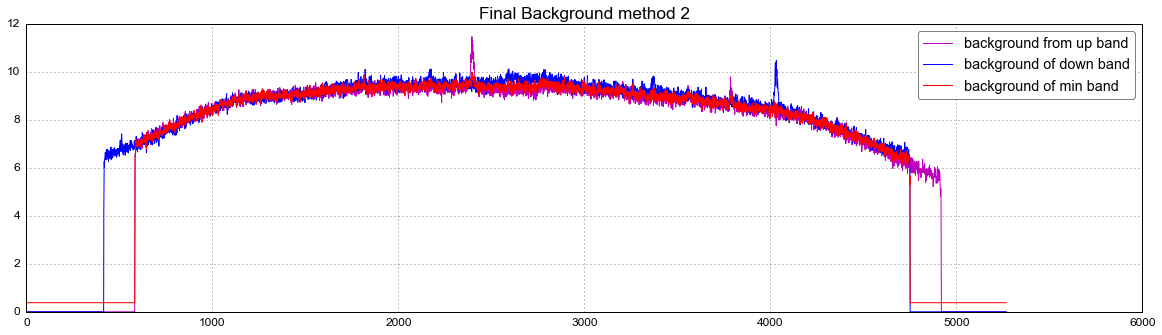

In [586]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(BackgUp2,color='m',label='background from up band')
ax.plot(BackgDo2,color='b',label='background of down band')
ax.plot(BackgMi2,color='r',label='background of min band')
#plt.ylim(0,4.5)
plt.legend()
plt.title('Final Background method 2')
plt.show()

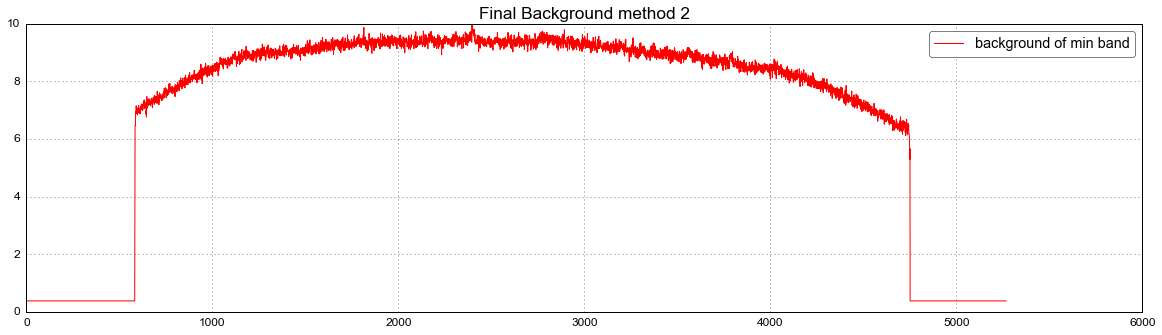

In [587]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(BackgMi2,color='r',label='background of min band')
#plt.ylim(0,4.5)
plt.legend()
plt.title('Final Background method 2')
plt.show()

In [588]:
FinalBackground2=np.zeros(SelectedSpectrumRegion.shape)
FinalBackground2[:,0:FinalBackground2.shape[1]]=BackgMi2

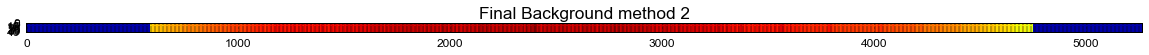

In [589]:
# plot the final background region
# ---------------------------------------
fig, ax1 = plt.subplots(1,1,figsize=(20, 5))
ax1.imshow(FinalBackground2,vmin=0,vmax=10.)
#plt.tight_layout()
plt.title('Final Background method 2')
plt.show()

In [590]:
if BackgroundSubtractionFlag1:
    FinalSpectrumRegion=SelectedSpectrumRegion-FinalBackground1  # this is the 2D subtraction
elif BackgroundSubtractionFlag2:
    FinalSpectrumRegion=SelectedSpectrumRegion-FinalBackground2  # this is the 2D subtraction
else:
    FinalSpectrumRegion=SelectedSpectrumRegion

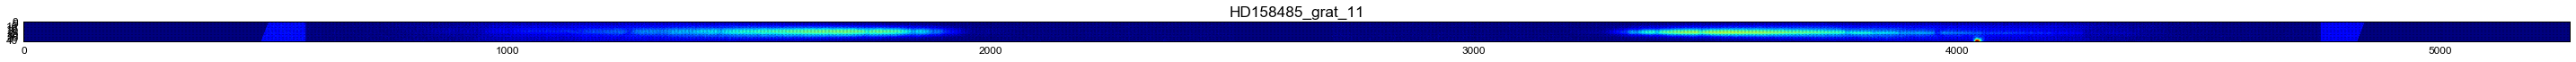

In [591]:
# Check the FinalSpectrumRegion
#----------------------------------------
fig, ax = plt.subplots(figsize=(40, 40))
ax.imshow(FinalSpectrumRegion,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
#plt.savefig(outputfigfilename5)

# Extract the 1D spectrum

In [592]:
#spectrum=np.sum(SelectedSpectrumRegion,axis=0)
spectrum=np.sum(FinalSpectrumRegion,axis=0)

In [593]:
spectrum

array([-15.14617958, -15.14617958, -15.14617958, ..., -15.14617958,
       -15.14617958, -15.14617958])

## 10.)  Plot the spectrum

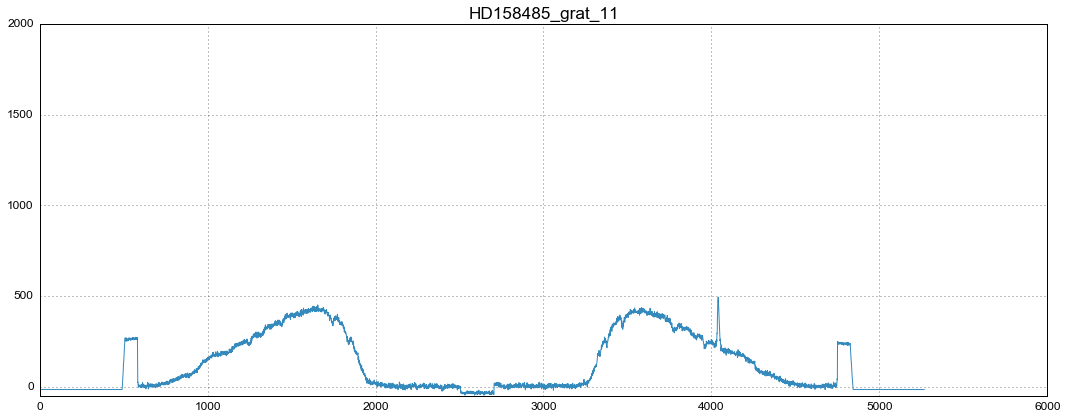

In [594]:
fig, ax = plt.subplots(figsize=(15, 6))
#plt.semilogy(spectrum)
plt.plot(spectrum)
plt.ylim(-50.,2000.)
plt.title(object_name)
plt.tight_layout()
#plt.xlim(0.,1000.)
plt.grid(True)
plt.savefig(outputfigfilename6)

In [595]:
spectrum[0:600]=0
spectrum[4600:]=0

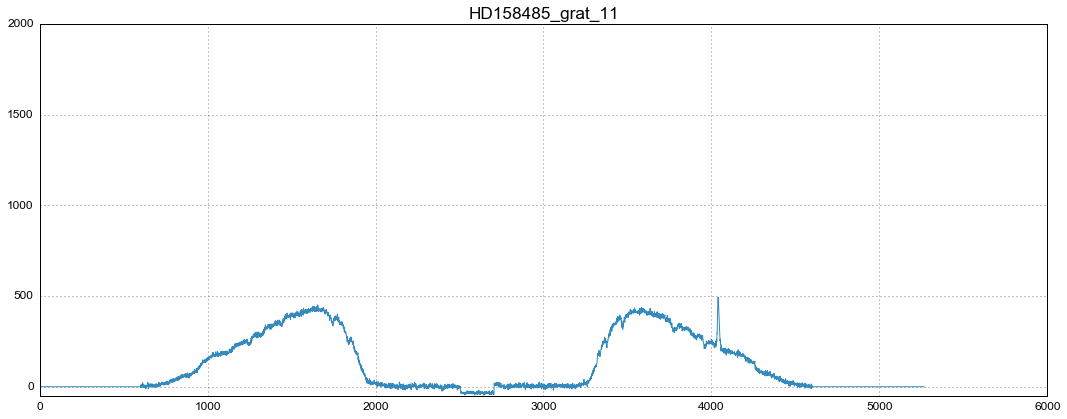

In [596]:
fig, ax = plt.subplots(figsize=(15, 6))
#plt.semilogy(spectrum)
plt.plot(spectrum)
plt.ylim(-50.,2000.)
plt.title(object_name)
plt.tight_layout()
#plt.xlim(0.,1000.)
plt.grid(True)
plt.savefig(outputfigfilename6)

In [597]:
def SeparateSpectra(inspectra,x0):
    '''
    Cut the two spectra
    '''
    rightspectra=inspectra[x0:]
    revleftspectra=inspectra[:x0]
    leftspectra=   revleftspectra[::-1]
    #rightspectra=rightspectra[np.where(rightspectra>0)]
    #leftspectra=leftspectra[np.where(leftspectra>0)]
    
    return leftspectra,rightspectra

In [598]:
def GetSpectrumBackground(inspectra,start,stop,skybg):
    '''
    Return the background    
    '''
    cropedbg=inspectra[start:stop]
    purebg=cropedbg[np.where(cropedbg!=skybg)]  # remove region of the bing star
    
    return purebg

In [599]:
def DiffSpectra(spec1,spec2,bg):
    '''
    Make the difference of the tow spectra 
    
    '''
    N1=spec1.shape[0]
    N2=spec2.shape[0]
    N=np.min([N1,N2])
    spec1_croped=spec1[0:N]
    spec2_croped=spec2[0:N]
    diff_spec=np.average((spec1_croped-spec2_croped)**2)/bg**2
    return diff_spec  

In [600]:
specbg=GetSpectrumBackground(spectrum,2000,3000,skybackground*wsel)

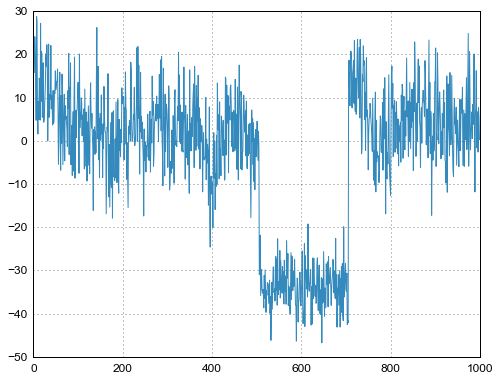

In [601]:
plt.plot(specbg)

In [602]:
bbg1=specbg[0:300]
bbg2=specbg[700:1000]
bbg3=[bbg1,bbg2]

In [603]:
avspecbg=np.median(bbg3)

rmsspecbg=specbg.std()

print 'spectra noise = {} +/- {} '.format(avspecbg,rmsspecbg)

spectra noise = 4.98529559124 +/- 17.0044486048 


In [604]:
spec1,spec2=SeparateSpectra(spectrum,2500)

(-50.0, 2000.0)

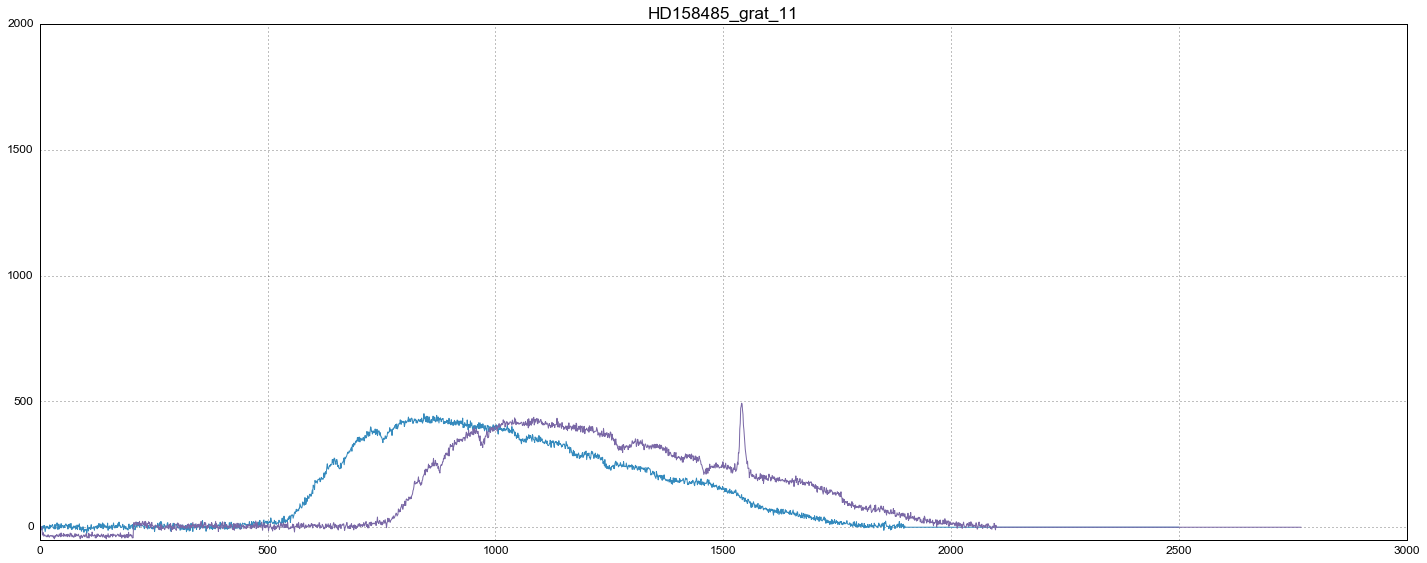

In [605]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(spec1)
ax.plot(spec2)
plt.title(object_name)
plt.tight_layout()
plt.ylim(-50.,2000.)


In [606]:
def FindCenter(fullspectrum,xmin,xmax,specbg):
    '''
    '''
    
    all_x0=np.arange(xmin,xmax,1)
    NBPOINTS=np.shape(all_x0)
    chi2=np.zeros(NBPOINTS)
    for idx,x0 in np.ndenumerate(all_x0):
        spec1,spec2=SeparateSpectra(fullspectrum,x0)
        chi2[idx]=DiffSpectra(spec1,spec2,specbg)
    return all_x0,chi2

In [607]:
origins,thechi2=FindCenter(spectrum,2000,3000,rmsspecbg)

(0, 200.0)

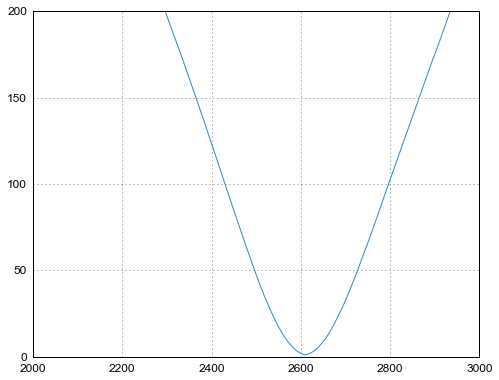

In [608]:
plt.plot(origins,thechi2)
plt.ylim(0,200.)

In [609]:
indexmin=np.where(thechi2==thechi2.min())[0]
theorigin=origins[indexmin]
print indexmin[0],theorigin[0],thechi2.min()

609 2609 1.183347967


In [610]:
print thechi2[515]

37.2141718316


In [611]:
spec1,spec2=SeparateSpectra(spectrum,theorigin[0])

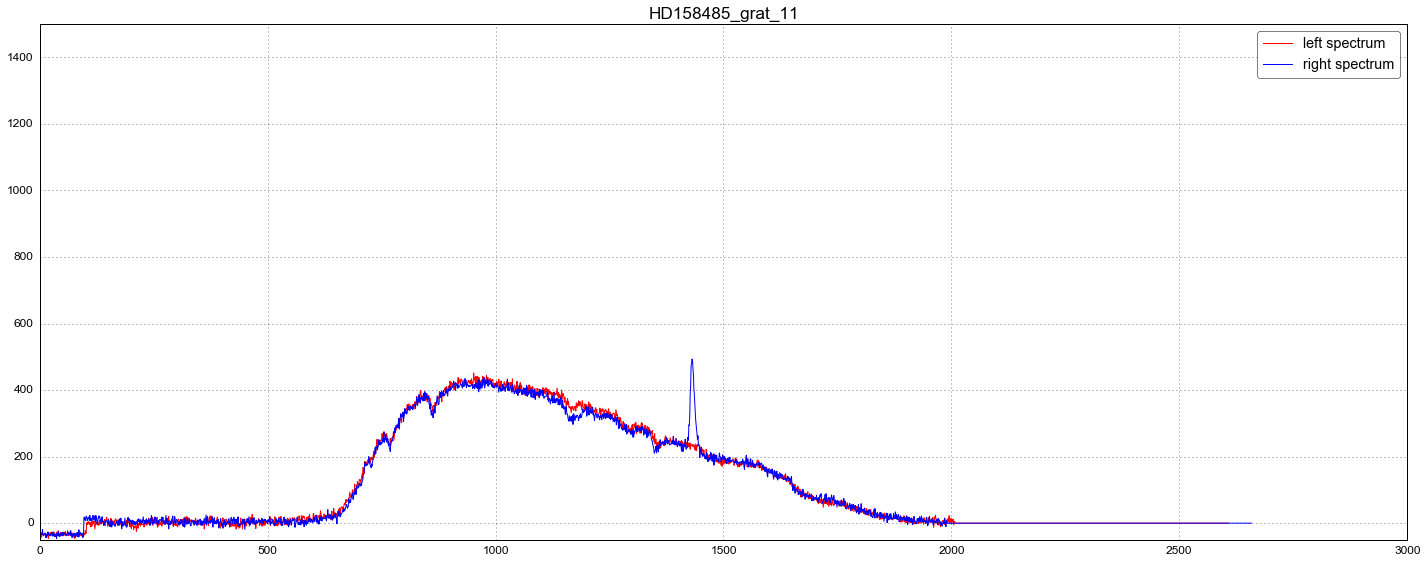

In [612]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(spec1,color='r',label='left spectrum')
ax.plot(spec2,color='b',label='right spectrum')
plt.title(object_name)
plt.legend(loc='best')
plt.ylim(-50.,1500.)
#plt.xlim(1300.,1600.)
plt.tight_layout()

In [613]:
spec2[1410:1450]=spec1[1410:1450] #night 09/05 and 10/05
#spec2[1360:1400]=spec1[1360:1400] bad corr

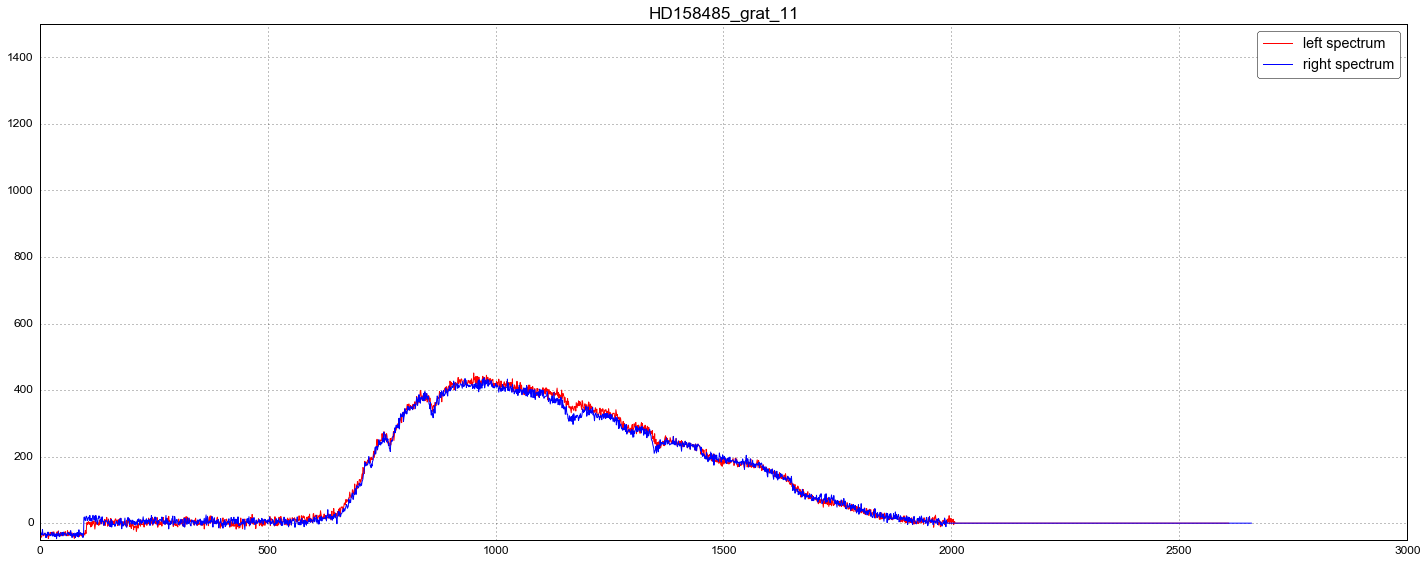

In [614]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(spec1,color='r',label='left spectrum')
ax.plot(spec2,color='b',label='right spectrum')
plt.title(object_name)
plt.legend(loc='best')
plt.ylim(-50.,1500.)
plt.tight_layout()

### Tiny amplitude correction

This correction must be applied, because I had not corrected for the differences in amplifier gain

In [615]:
bbbg1=spec1[0:300]
bbbg2=spec2[0:300]
bbbg=0.5*(bbbg1.std()+bbbg2.std())
print bbbg

18.9295823348


In [616]:
gains=np.linspace(0.5,1.5,1000)
NBGAINS=gains.shape[0]
chi2New=np.zeros(NBGAINS)

In [617]:
def DiffAmplitudes(sp1,sp2,gain,basebg):
    '''
    get the differences of the spectra for that gain
    '''    
    return DiffSpectra(sp1,gain*sp2,basebg)

In [618]:
for idx,gain in np.ndenumerate(gains):
    chi2New[idx]=DiffAmplitudes(spec1,spec2,gain,bbbg)
    

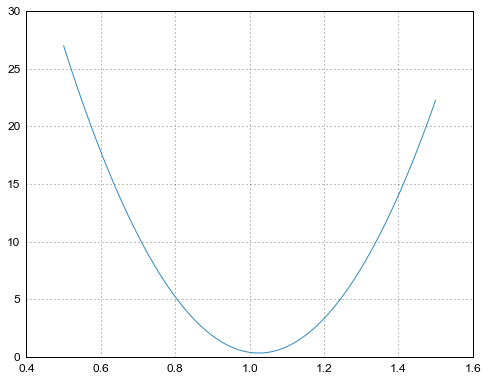

In [619]:
plt.plot(gains,chi2New)
#plt.ylim(0,200.)

In [620]:
thegain=gains[np.where(chi2New==chi2New.min())]

In [621]:
print thegain

[ 1.02452452]


In [622]:
spec2=spec2*thegain

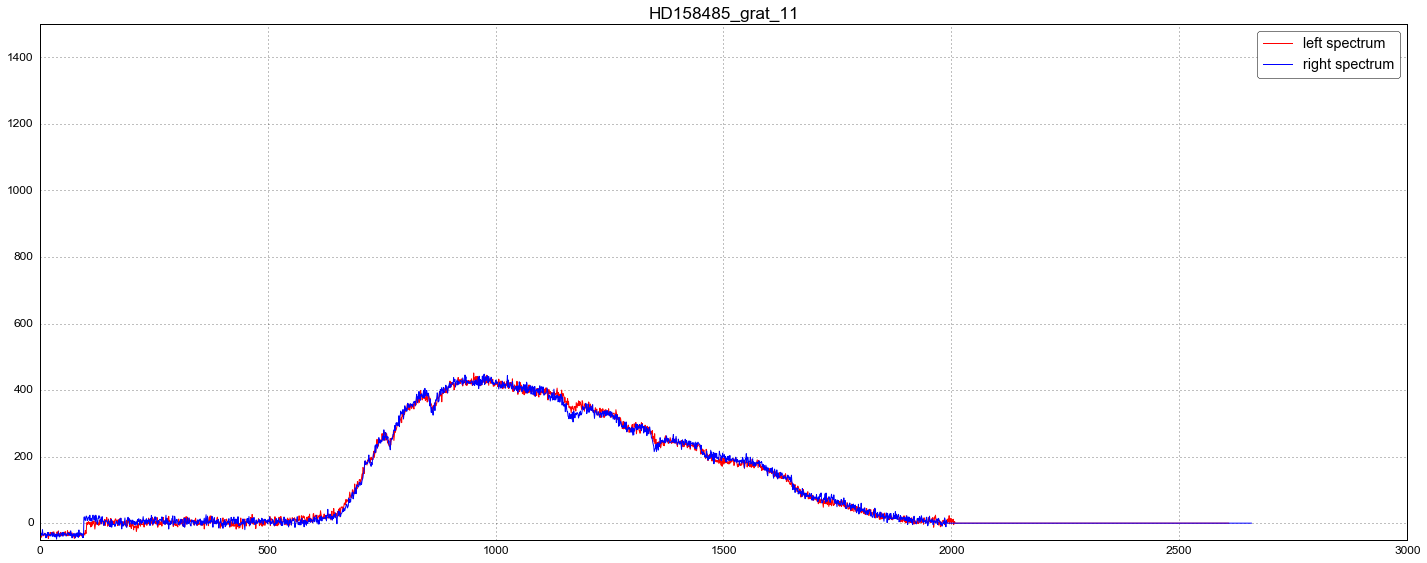

In [623]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(spec1,color='r',label='left spectrum')
ax.plot(spec2,color='b',label='right spectrum')
plt.title(object_name)
plt.legend(loc='best')
plt.ylim(-50.,1500.)
plt.tight_layout()

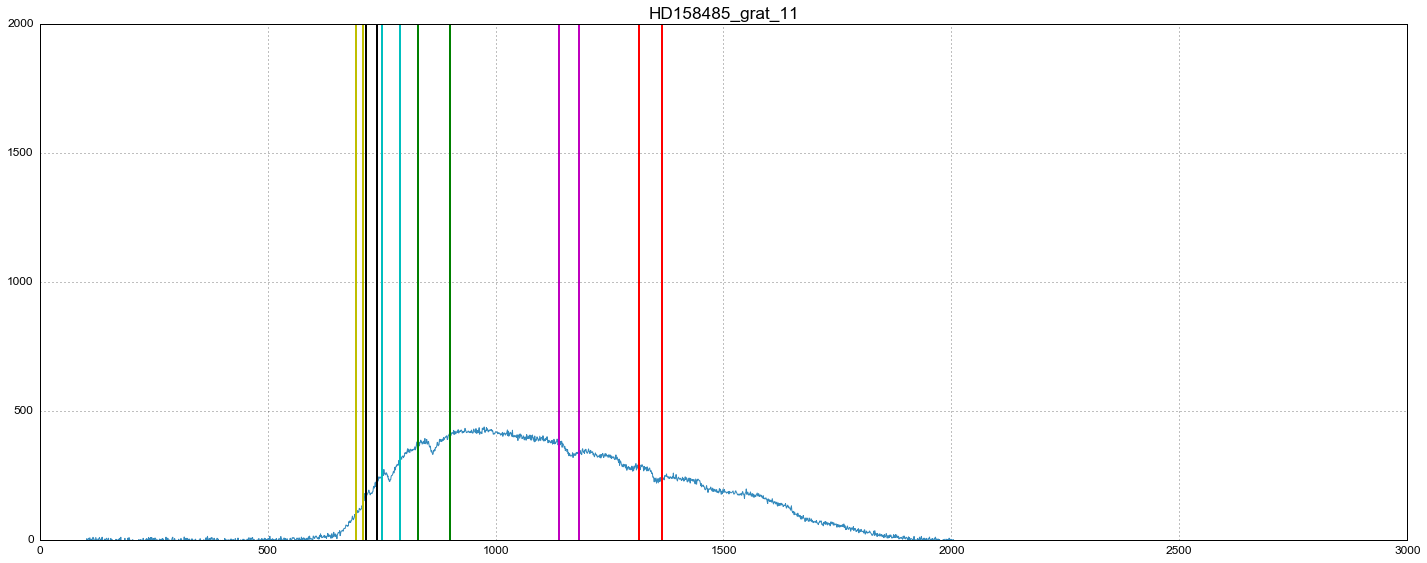

In [624]:
N1=spec1.shape[0]
N2=spec2.shape[0]
N=np.min([N1,N2])
spec1_croped=spec1[0:N]
spec2_croped=spec2[0:N]
specsum=0.5*(spec1_croped+spec2_croped)-avspecbg

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(specsum)


# O2 Frauwnoffer A 759.370
ax.plot([1315, 1315], [-200,2000], color='r', linestyle='-', linewidth=2)
ax.plot([1365, 1365], [-200,2000], color='r', linestyle='-', linewidth=2)

# H-alpha : Hα     656.281 nm
ax.plot([1140, 1140], [-200,2000], color='m', linestyle='-', linewidth=2)
ax.plot([1182, 1182], [-200,2000], color='m', linestyle='-', linewidth=2)

# H-beta : Hβ     486.134 nm
ax.plot([830, 830], [-200,2000], color='g', linestyle='-', linewidth=2)
ax.plot([900, 900], [-200,2000], color='g', linestyle='-', linewidth=2)

# H-gamma : Hγ     434.047 nm
ax.plot([750, 750], [-200,2000], color='c', linestyle='-', linewidth=2)
ax.plot([790, 790], [-200,2000], color='c', linestyle='-', linewidth=2)


# H-delta : Hδ     410.175 nm
ax.plot([715, 715], [-200,2000], color='k', linestyle='-', linewidth=2)
ax.plot([740, 740], [-200,2000], color='k', linestyle='-', linewidth=2)

# H-epsilon : H epsilon 397,0 nm
ax.plot([693, 693], [-200,2000], color='y', linestyle='-', linewidth=2)
ax.plot([710, 710], [-200,2000], color='y', linestyle='-', linewidth=2)



plt.ylim(0.,2000.)

plt.title(object_name)
plt.tight_layout()

In [625]:
peak_O2=np.min(specsum[1315:1365])
indexes_O2=np.where(specsum==peak_O2)
print indexes_O2, peak_O2

(array([1353]),) 219.756535465


In [626]:
peak_Halpha=np.min(specsum[1140:1182])
indexes_Halpha=np.where(specsum==peak_Halpha)
print indexes_Halpha, peak_Halpha

(array([1170]),) 319.100347785


In [627]:
peak_Hbeta=np.min(specsum[830:900])
indexes_Hbeta=np.where(specsum==peak_Hbeta)
print indexes_Hbeta, peak_Hbeta

(array([862]),) 331.146516749


In [628]:
peak_Hgamma=np.min(specsum[750:790])
indexes_Hgamma=np.where(specsum==peak_Hgamma)
print indexes_Hgamma, peak_Hgamma

(array([767]),) 226.387346789


In [629]:
peak_Hdelta=np.min(specsum[715:740])
indexes_Hdelta=np.where(specsum==peak_Hdelta)
print indexes_Hdelta, peak_Hdelta

(array([715]),) 172.052443107


In [630]:
peak_Hepsilon=np.min(specsum[693:710])
indexes_Hepsilon=np.where(specsum==peak_Hepsilon)
print indexes_Hepsilon, peak_Hepsilon

(array([694]),) 87.0250350567


In [631]:
pixel_axis=np.array([0, indexes_Hepsilon[0] ,indexes_Hdelta[0], indexes_Hgamma[0], indexes_Hbeta[0],indexes_Halpha[0], indexes_O2[0]])

In [632]:
wavelength_axis=np.array([0, 397.0, 410.175, 434.047,486.134, 656.281, 759.370])

In [633]:
pixel_to_wavelength_fit_p1d=np.poly1d(np.polyfit(pixel_axis,wavelength_axis,1))
wavelength_to_pixel_fit_p1d =np.poly1d( np.polyfit(wavelength_axis,pixel_axis,1))


(0, 1500.0)

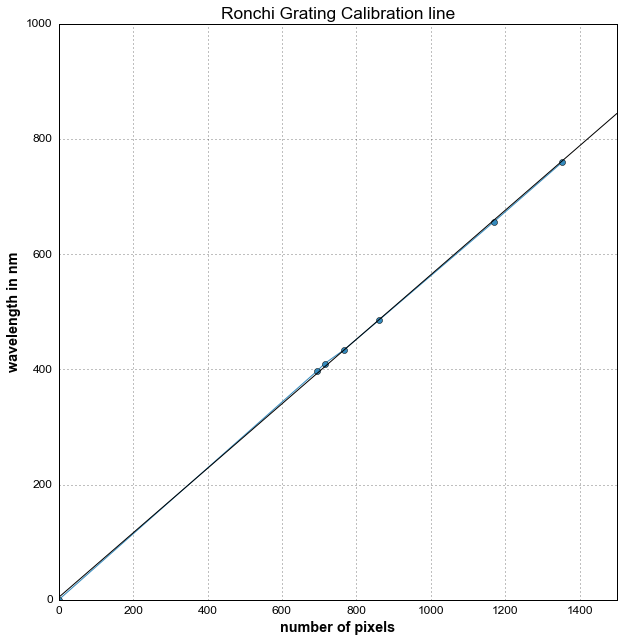

In [634]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(pixel_axis,wavelength_axis,'o-')
pt_XMIN=0
pt_XMAX=1500
pt_YMIN=pixel_to_wavelength_fit_p1d(pt_XMIN)
pt_YMAX=pixel_to_wavelength_fit_p1d(pt_XMAX)
plt.plot([pt_XMIN,pt_XMAX],[pt_YMIN,pt_YMAX],'k-')
plt.title('Ronchi Grating Calibration line')
plt.xlabel('number of pixels')
plt.ylabel('wavelength in nm')
plt.ylim(0,1000.)
plt.xlim(0,1500.)
#plt.annotate('$O_2$', xy=(1200,763.370), xytext=(1000,763.37),fontsize=30,
#            arrowprops=dict(facecolor='black', shrink=0.02))
#plt.annotate('$H_{alpha}$', xy=(1200,658.281), xytext=(1000,658.281),fontsize=30,
#            arrowprops=dict(facecolor='black', shrink=0.02))
#plt.annotate('$H_{beta}$', xy=(1100,486.281), xytext=(900,486.281),fontsize=30,
#           arrowprops=dict(facecolor='black', shrink=0.02))
#plt.annotate('$H_{gamma}$', xy=(800,434.281), xytext=(600,385.281),fontsize=30,
#           arrowprops=dict(facecolor='black', shrink=0.02))
#plt.annotate('$H_{delta}$', xy=(600,410.500), xytext=(400,410.281),fontsize=30,
#            arrowprops=dict(facecolor='black', shrink=0.02))

In [635]:
from scipy.interpolate import UnivariateSpline

In [636]:
pixel_to_wavelength_spl = UnivariateSpline(pixel_axis,wavelength_axis)

In [637]:
wavelehgth_to_pixel_spl = UnivariateSpline(wavelength_axis,pixel_axis)

In [638]:
pixel_to_wavelength_spl(indexes_O2[0])

array([ 759.60789574])

In [639]:
index_O2=np.where(specsum==peak_O2)

In [640]:
pixel_axis.shape

(7,)

In [641]:
wavelength_axis.shape

(7,)

###  Does a  linear fit

For 
This is the linear equation

In [642]:
#np.polyfit(pixel_axis[:,0],wavelength_axis,1,full=True)
np.polyfit(pixel_axis,wavelength_axis,1)

array([ 0.55985577,  4.23557835])

In [643]:
specsum_indexes=np.arange(specsum.shape[0])

In [644]:
#specsum_wavelength=pixel_to_wavelength_spl(specsum_indexes) Do not use interpolation
specsum_wavelength=pixel_to_wavelength_fit_p1d(specsum_indexes) # use the fit equation

(0.0, 1000.0)

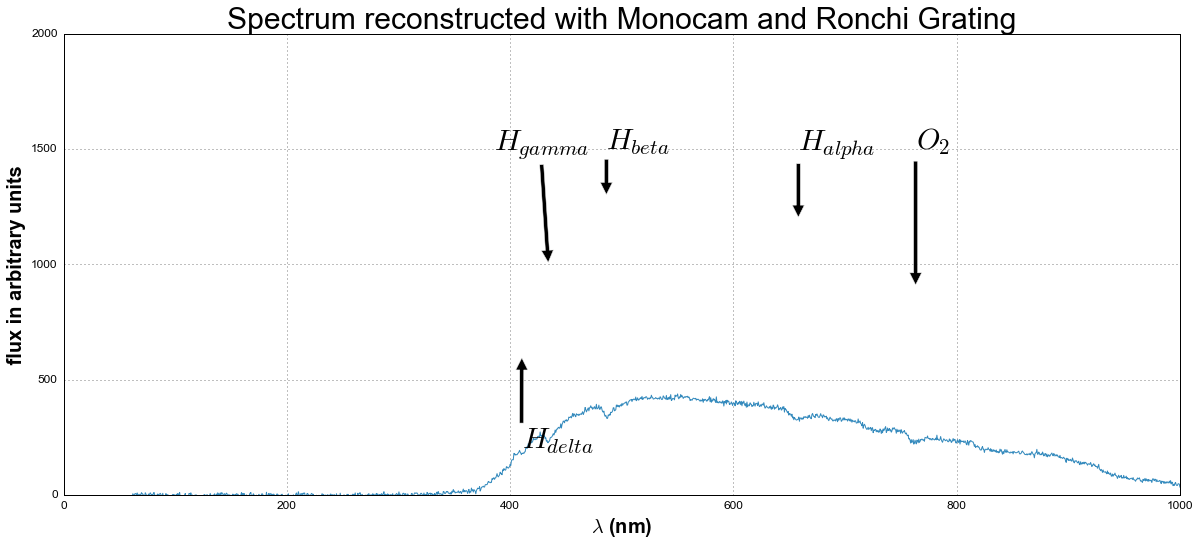

In [645]:
plt.figure(figsize=(20.,8.))
plt.plot(specsum_wavelength,specsum)
plt.title('Spectrum reconstructed with Monocam and Ronchi Grating',fontsize=30)
plt.xlabel('$\lambda$ (nm)',fontsize=20)
plt.ylabel(' flux in arbitrary units ',fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylim(-100.,1500.)
plt.annotate('$O_2$', xy=(763.370,900), xytext=(763.37, 1500),fontsize=30,
            arrowprops=dict(facecolor='black', shrink=0.02))
plt.annotate('$H_{alpha}$', xy=(658.281,1200), xytext=(658.281, 1500),fontsize=30,
            arrowprops=dict(facecolor='black', shrink=0.02))
plt.annotate('$H_{beta}$', xy=(486.281,1300), xytext=(486.281,1500),fontsize=30,
           arrowprops=dict(facecolor='black', shrink=0.02))
plt.annotate('$H_{gamma}$', xy=(434.281,1000), xytext=(385.281, 1500),fontsize=30,
           arrowprops=dict(facecolor='black', shrink=0.02))
plt.annotate('$H_{delta}$', xy=(410.500,600), xytext=(410.281,200),fontsize=30,
            arrowprops=dict(facecolor='black', shrink=0.02))
#wavelength_axis=np.array([397.0, 410.175, 434.047,486.134, 656.281, 759.370])
plt.ylim(0.,2000.)
plt.xlim(0.,1000.)

## SED

In [646]:

path_sed='../SED'
obj_name='hd158485'
airmass='1.1'
night_name='20160511'
tablefitsfile_sed='SEDPred_'+obj_name+'_'+night_name+'_'+str(fileindex)+'.fits'

In [647]:
fullfilename_sed=os.path.join(path_sed,tablefitsfile_sed)

In [648]:
hdulist=fits.open(fullfilename_sed)
hdulist.info()


Filename: ../SED/SEDPred_hd158485_20160511_11.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       7   ()              
1                BinTableHDU     18   3729R x 5C   [E, E, E, E, E]   


In [649]:
table_data=hdulist[1].data
table_data.columns  # shows the columns names of the table

ColDefs(
    name = 'WAVELENGTH'; format = 'E'
    name = 'SEDcalspec'; format = 'E'
    name = 'SEDxQE'; format = 'E'
    name = 'SEDxQExATM'; format = 'E'
    name = 'SEDxQExATMxTopt'; format = 'E'
)

In [650]:
wavelength_sed=table_data.field('WAVELENGTH')
flux_sed=table_data.field('SEDcalspec')
flux_sedccd=table_data.field('SEDxQE')
flux_sedccdatm=table_data.field('SEDxQExATM')
flux_sedccdatmopt=table_data.field('SEDxQExATMxTopt')

In [651]:
SED1=flux_sed
SED2=flux_sedccd
SED3=flux_sedccdatm
SED4=flux_sedccdatmopt

In [652]:
SED5=SED4

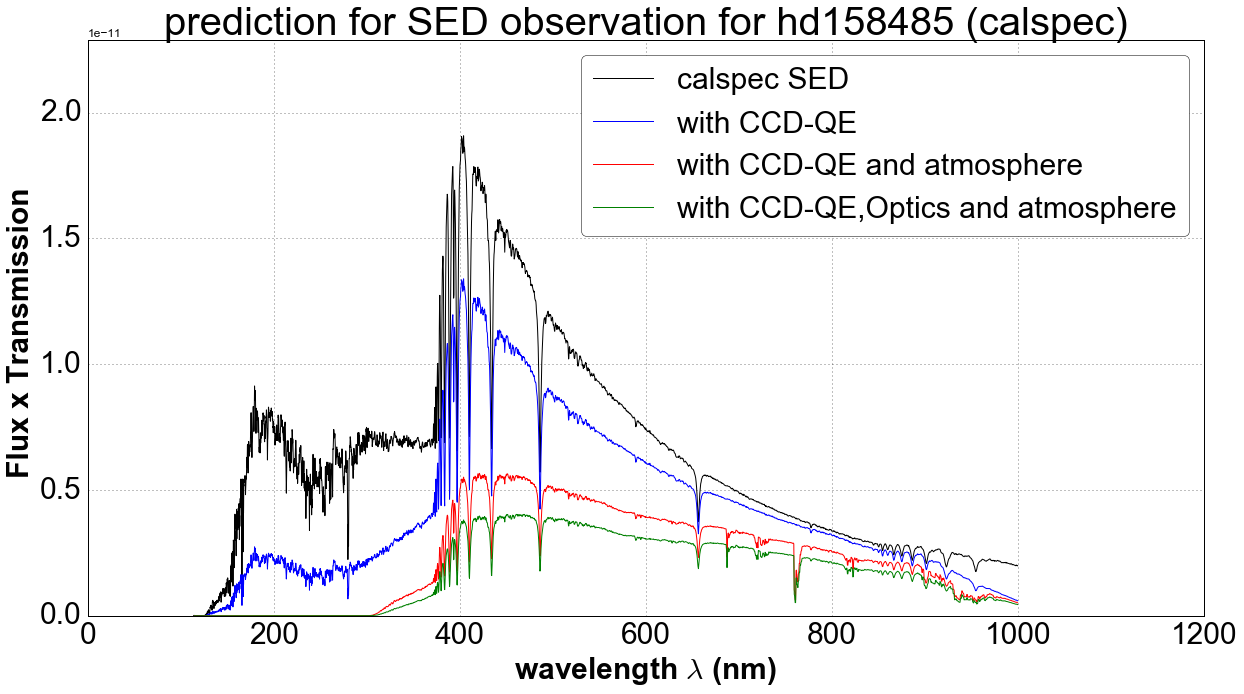

In [653]:
plt.figure(figsize=(20,10))
plt.plot(wavelength_sed,SED1,label='calspec SED',color='k')
plt.plot(wavelength_sed,SED2,label='with CCD-QE',color='b')
plt.plot(wavelength_sed,SED3,label='with CCD-QE and atmosphere',color='r')
plt.plot(wavelength_sed,SED4,label='with CCD-QE,Optics and atmosphere',color='g')
plt.xlim(0,1200.)
plt.ylim(0,SED1.max()*1.2)
plt.title('prediction for SED observation for hd158485 (calspec)',fontsize=40)
plt.xlabel('wavelength $\lambda$ (nm)',fontsize=30)
plt.ylabel('Flux x Transmission ',fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.legend(fontsize=30)
plt.show()

(0.0, 1000.0)

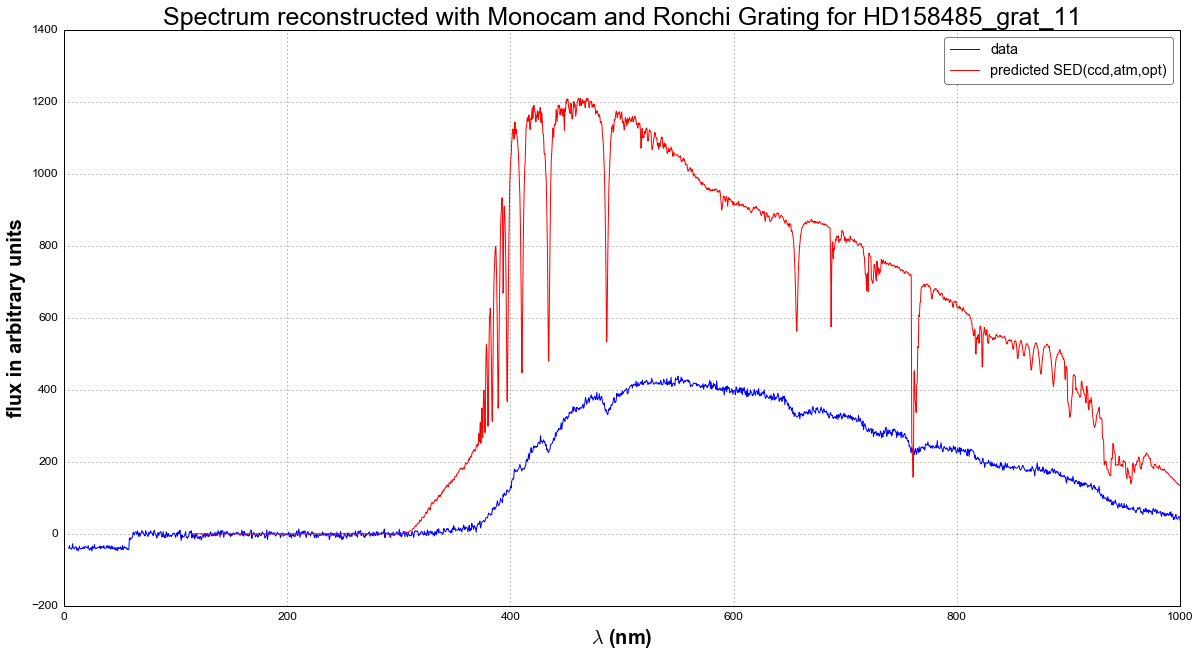

In [654]:
plt.figure(figsize=(20.,10.))
plt.plot(specsum_wavelength,specsum,label='data',color='b')
plt.plot(wavelength_sed,SED5*3e14,label='predicted SED(ccd,atm,opt)',color='r')
the_title='Spectrum reconstructed with Monocam and Ronchi Grating for {}'.format(object_name)
plt.title(the_title,fontsize=25)
plt.xlabel('$\lambda$ (nm)',fontsize=20)
plt.ylabel(' flux in arbitrary units ',fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.legend(loc='best')
plt.xlim(0.,1000.)

## save spectrum in a file 

In [655]:
#path
spectrum_path=path='./HD158485_grat'+'_spectra'

In [656]:
# basefilename
basespectrumfilename='dataspec_'+object_name+'.fits'

In [657]:
# full output filename
fullspectrumfilename=os.path.join(spectrum_path,basespectrumfilename)

In [658]:
# keep the original header
primheader=prim_hdr

In [659]:
# add the object name
primheader['OBJNAME']=object_name

In [660]:
# define the primary fits unit
primhdu=fits.PrimaryHDU(header=primheader)

In [661]:
# define the columns of the fits table
col1 = fits.Column(name='WAVELENGTH', format='E', array=specsum_wavelength)
col2 = fits.Column(name='SPECTRUMDATA', format='E', array=specsum)

In [662]:
# define the fits Extension unit for the spectrum data
cols = fits.ColDefs([col1, col2])     # definition of the column
tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU

In [663]:
# save data and SED prediction
thdulist = fits.HDUList([primhdu, tbhdu,hdulist[1]])
thdulist.writeto(fullspectrumfilename,clobber=True)